In [1]:
from tensorflow.keras.models import Sequential ,load_model
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import tensorflow_datasets as tfds

2025-06-09 12:14:24.164852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749471264.346132      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749471264.400462      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import kagglehub
path = kagglehub.dataset_download("nareshlankalapalli/paddy-disease")

In [3]:
import os
import shutil

# Step 1: Copy test folder to working directory
src = '/kaggle/input/paddy-disease/rice_disease_data/test'
dst = '/kaggle/working/test_fixed1'

# Copy directory tree
shutil.copytree(src, dst)

# Step 2: Rename inside working directory
rename_map = {
    'Neck_Blast': 'neck_blast',
    'Rice Hispa': 'rice_hispa',
    'Sheath Blight': 'sheath_blight',
    'Tungro': 'tungro'
}

for old_name, new_name in rename_map.items():
    old_path = os.path.join(dst, old_name)
    new_path = os.path.join(dst, new_name)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed: {old_name} ➝ {new_name}")
    else:
        print(f"Folder not found: {old_name}")


Renamed: Neck_Blast ➝ neck_blast
Renamed: Rice Hispa ➝ rice_hispa
Renamed: Sheath Blight ➝ sheath_blight
Renamed: Tungro ➝ tungro


In [4]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image settings
img_size = 224  # or your preferred size
batch_size = 32
train_dir = '/kaggle/input/paddy-disease/rice_disease_data/train'
#test_dir = '/kaggle/input/paddy-disease/rice_disease_data/test'

# Create training and validation ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training'  # Subset for training
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation'  # Subset for validation
)

# Testing generator
test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/test_fixed1',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 11607 images belonging to 10 classes.
Found 2899 images belonging to 10 classes.
Found 3422 images belonging to 10 classes.


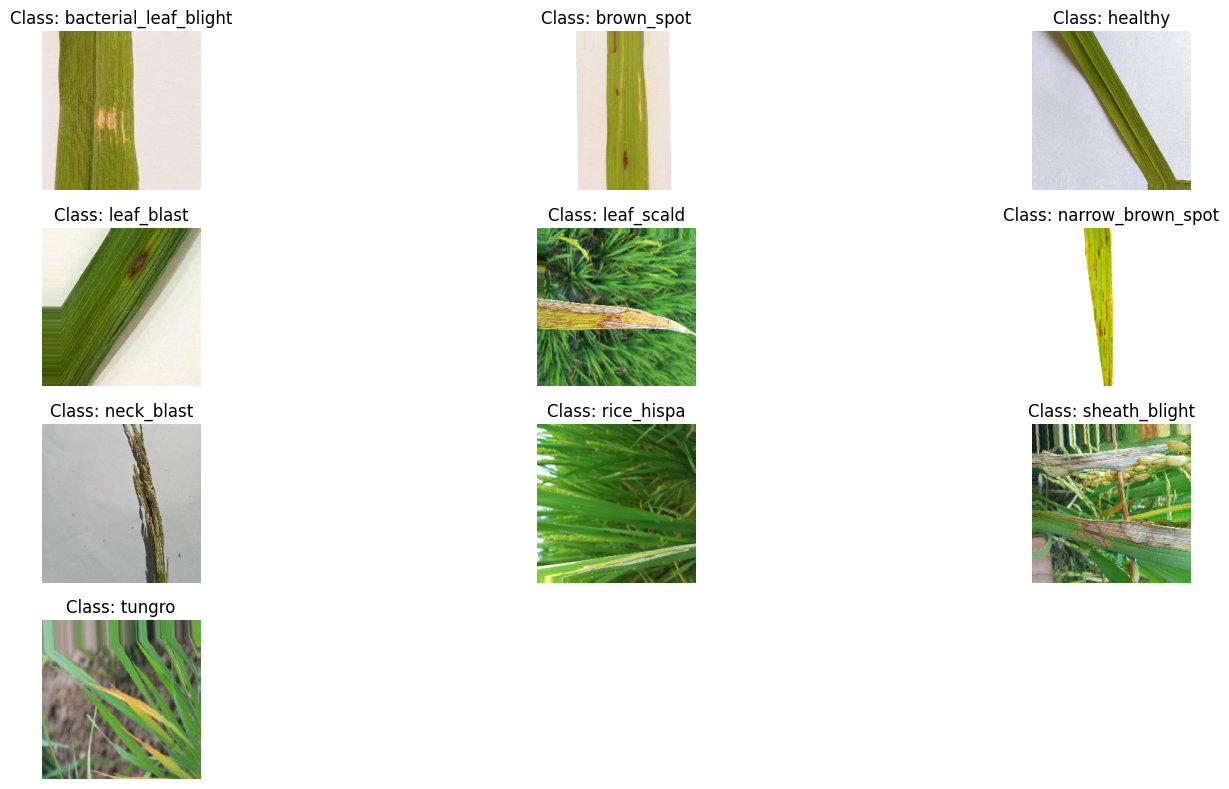

In [5]:
import random
# Automatically get class folder names
class_names= ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']

# Plot one random image from each class folder
plt.figure(figsize=(15, 8))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    if not image_files:
        print(f"No images found in {class_name}")
        continue

    # Randomly select one image
    selected_image = random.choice(image_files)
    img_path = os.path.join(class_path, selected_image)
    img = load_img(img_path, target_size=(img_size,img_size,3))

    plt.subplot(4, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tqdm import tqdm
import shutil

# PARAMETERS
dataset_path = '/kaggle/working/test_fixed1'
target_size = 224
TARGET_IMAGES = 350

# Data augmenter
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(image_files)

    print(f"\n🔍 Class '{class_name}': {current_count} images")

    # ----------- CASE 1: Downsample if more than needed -----------
    if current_count > TARGET_IMAGES:
        print(f"⚠️ Too many images. Downsampling to {TARGET_IMAGES}...")
        random.shuffle(image_files)
        keep_files = image_files[:TARGET_IMAGES]
        delete_files = set(image_files) - set(keep_files)

        for file_name in delete_files:
            try:
                os.remove(os.path.join(class_path, file_name))
            except Exception as e:
                print(f"Error deleting {file_name}: {e}")
        print(f"✅ Downsampled '{class_name}' to {TARGET_IMAGES} images.")

    # ----------- CASE 2: Augment if fewer than needed -----------
    elif current_count < TARGET_IMAGES:
        needed = TARGET_IMAGES - current_count
        print(f"🔄 Generating {needed} new images...")

        i = 0
        pbar = tqdm(total=needed, desc=f"Augmenting '{class_name}'")
        while i < needed:
            for img_name in image_files:
                img_path = os.path.join(class_path, img_name)
                try:
                    img = load_img(img_path, target_size=(target_size, target_size))
                    x = img_to_array(img)
                    x = np.expand_dims(x, axis=0)

                    aug_iter = augmenter.flow(x, batch_size=1)
                    aug_img = next(aug_iter)[0].astype(np.uint8)

                    save_name = f"aug_{i}_{img_name}"
                    save_path = os.path.join(class_path, save_name)
                    save_img(save_path, aug_img)

                    i += 1
                    pbar.update(1)

                    if i >= needed:
                        break
                except Exception as e:
                    print(f"Error processing {img_name}: {e}")
                    continue
        pbar.close()
        print(f"✅ Augmentation complete for class '{class_name}'.")

    # ----------- CASE 3: Already balanced -----------
    else:
        print("✅ Already has exactly 350 images. Skipping.")



🔍 Class 'sheath_blight': 288 images
🔄 Generating 62 new images...


Augmenting 'sheath_blight': 100%|██████████| 62/62 [00:01<00:00, 32.66it/s]


✅ Augmentation complete for class 'sheath_blight'.

🔍 Class 'neck_blast': 322 images
🔄 Generating 28 new images...


Augmenting 'neck_blast': 100%|██████████| 28/28 [00:02<00:00, 12.53it/s]


✅ Augmentation complete for class 'neck_blast'.

🔍 Class 'narrow_brown_spot': 382 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'narrow_brown_spot' to 350 images.

🔍 Class 'leaf_blast': 362 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'leaf_blast' to 350 images.

🔍 Class 'tungro': 310 images
🔄 Generating 40 new images...


Augmenting 'tungro': 100%|██████████| 40/40 [00:00<00:00, 65.18it/s]


✅ Augmentation complete for class 'tungro'.

🔍 Class 'healthy': 391 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'healthy' to 350 images.

🔍 Class 'rice_hispa': 225 images
🔄 Generating 125 new images...


Augmenting 'rice_hispa': 100%|██████████| 125/125 [00:03<00:00, 36.47it/s]

✅ Augmentation complete for class 'rice_hispa'.

🔍 Class 'brown_spot': 380 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'brown_spot' to 350 images.

🔍 Class 'leaf_scald': 386 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'leaf_scald' to 350 images.

🔍 Class 'bacterial_leaf_blight': 376 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'bacterial_leaf_blight' to 350 images.


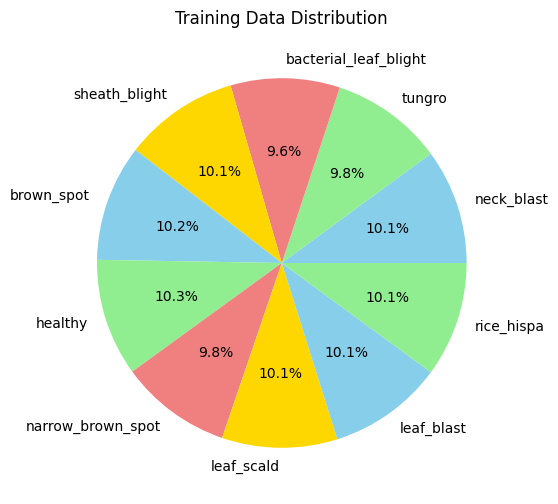

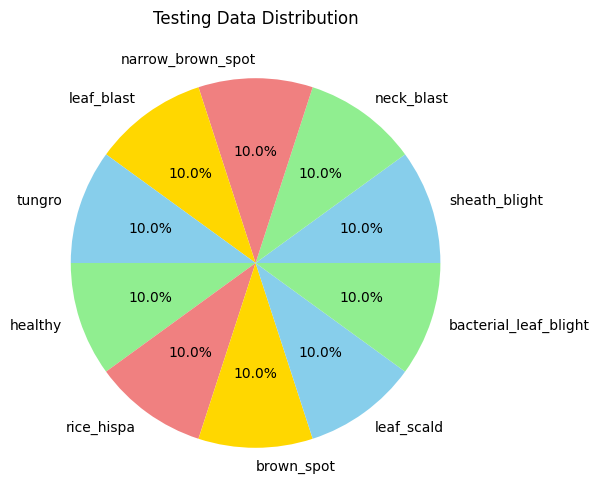

Training Data Counts:
neck_blast: 1461 images
tungro: 1428 images
bacterial_leaf_blight: 1386 images
sheath_blight: 1458 images
brown_spot: 1480 images
healthy: 1491 images
narrow_brown_spot: 1416 images
leaf_scald: 1465 images
leaf_blast: 1460 images
rice_hispa: 1461 images

Testing Data Counts:
sheath_blight: 350 images
neck_blast: 350 images
narrow_brown_spot: 350 images
leaf_blast: 350 images
tungro: 350 images
healthy: 350 images
rice_hispa: 350 images
brown_spot: 350 images
leaf_scald: 350 images
bacterial_leaf_blight: 350 images


In [7]:
# Function to count images in each class
def count_images(dataset_path):
    class_counts = {}
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            num_images = len(os.listdir(label_path))
            class_counts[label] = num_images
    return class_counts

# Count images in training and testing datasets
train_counts = count_images(train_dir)
test_counts = count_images('/kaggle/working/test_fixed1')

# Plot pie charts
def plot_pie_chart(class_counts, title):
    labels = list(class_counts.keys())
    sizes = list(class_counts.values())
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0, colors=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title(title)
    plt.show()

# Plot for training data
plot_pie_chart(train_counts, "Training Data Distribution")

# Plot for testing data
plot_pie_chart(test_counts, "Testing Data Distribution")

# Print the number of images in each class
print("Training Data Counts:")
for label, count in train_counts.items():
    print(f"{label}: {count} images")

print("\nTesting Data Counts:")
for label, count in test_counts.items():
    print(f"{label}: {count} images")

In [8]:
import os,  random, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.utils import to_categorical, plot_model
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img

In [9]:
from tensorflow.keras import regularizers
num_classes=10
def conv_block(x, filters, kernel_size=3, stride=1, downsample=False):
    identity = x
    y = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4))(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    y = layers.Conv2D(filters, kernel_size, strides=1, padding='same',
                      kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4))(y)
    y = layers.BatchNormalization()(y)
    if downsample or x.shape[-1] != filters:
        identity = layers.Conv2D(filters, 1, strides=stride, padding='same',
                                 kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4))(identity)
        identity = layers.BatchNormalization()(identity)
    y = layers.Add()([y, identity])
    y = layers.ReLU()(y)
    y = layers.Dropout(0.3)(y)  # Dropout added
    return y

def build_resnet18(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = conv_block(x, 64)
    x = conv_block(x, 64)
    x = conv_block(x, 128, stride=2, downsample=True)
    x = conv_block(x, 128)
    x = conv_block(x, 256, stride=2, downsample=True)
    x = conv_block(x, 256)
    x = conv_block(x, 512, stride=2, downsample=True)
    x = conv_block(x, 512)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Dropout before classification

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)
model = build_resnet18(input_shape=(224, 224, 3), num_classes=num_classes)

# Freeze the layers of InceptionV3 so they are not trained again
#base_model.trainable = True

I0000 00:00:1749471329.323132      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
 # Dropout for regularization


initial_lr = 0.001

def scheduler(epoch, lr):
    if epoch > 5:
        return lr * 0.5
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

opt = tf.keras.optimizers.Adam(learning_rate=initial_lr)

# Label smoothing = 0.1 to reduce overconfidence
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])



In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 56, 56, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 56, 56, 64)     │              0 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)    

 Total params: 11,196,042 (42.71 MB)

 Trainable params: 11,186,442 (42.67 MB)

 Non-trainable params: 9,600 (37.50 KB)

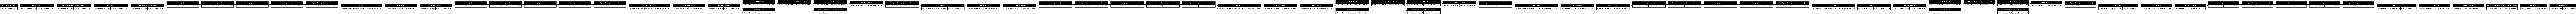

In [12]:


plot_model(model, to_file='/kaggle/working/paddy_leaf_cnn_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

# Display block diagram
try:
    display(Image(filename='/kaggle/working/paddy_leaf_cnn_model.png'))
except NameError: # Catch NameError if Image is not defined
    print("Model plot saved as 'paddy_leaf_cnn_model.png'")

In [13]:
# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [14]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1749471353.098507     119 service.cc:148] XLA service 0x7840580052d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749471353.099372     119 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749471355.150156     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/363 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.0781 - loss: 4.4909   

I0000 00:00:1749471369.240486     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


363/363 ━━━━━━━━━━━━━━━━━━━━ 344s 849ms/step - accuracy: 0.4170 - loss: 2.9454 - val_accuracy: 0.3353 - val_loss: 21.3765
Epoch 2/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 217s 597ms/step - accuracy: 0.6655 - loss: 1.8695 - val_accuracy: 0.2994 - val_loss: 14.2262
Epoch 3/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 212s 584ms/step - accuracy: 0.7239 - loss: 1.5849 - val_accuracy: 0.4833 - val_loss: 2.1493
Epoch 4/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 206s 569ms/step - accuracy: 0.7505 - loss: 1.3701 - val_accuracy: 0.5316 - val_loss: 5.4391
Epoch 5/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 203s 559ms/step - accuracy: 0.7720 - loss: 1.1852 - val_accuracy: 0.3732 - val_loss: 6.1604
Epoch 6/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 208s 574ms/step - accuracy: 0.7847 - loss: 1.0635 - val_accuracy: 0.6671 - val_loss: 1.4828
Epoch 7/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 210s 577ms/step - accuracy: 0.8003 - loss: 0.9531 - val_accuracy: 0.6378 - val_loss: 2.5066
Epoch 8/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 213s 588ms/step - accuracy: 0.8038 - loss: 0.

91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 465ms/step - accuracy: 0.5158 - loss: 2.7450
Test Accuracy: 50.98%


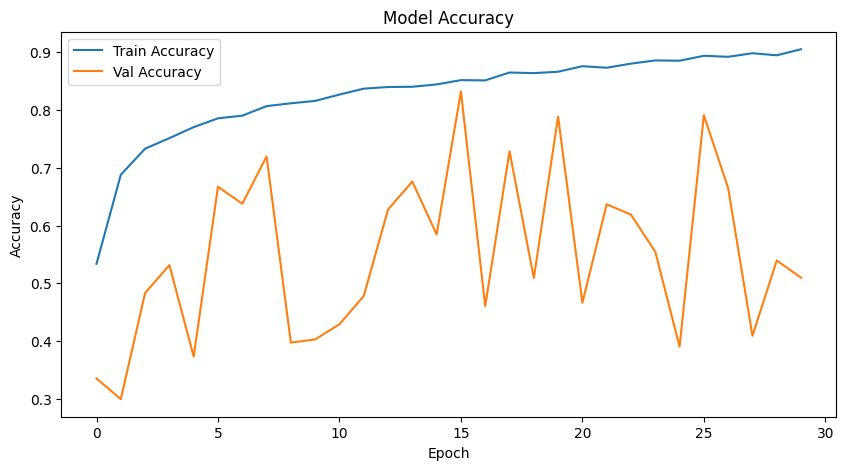

In [15]:
loss, acc = model.evaluate(validation_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Plot accuracy graph

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


In [16]:
model.save('/kaggle/working/paddy_leaf_cnn_model/trained _models/chilli_leaf_vgg16_model.h5')


Found 11607 images belonging to 10 classes.
Found 2899 images belonging to 10 classes.
91/91 ━━━━━━━━━━━━━━━━━━━━ 45s 481ms/step


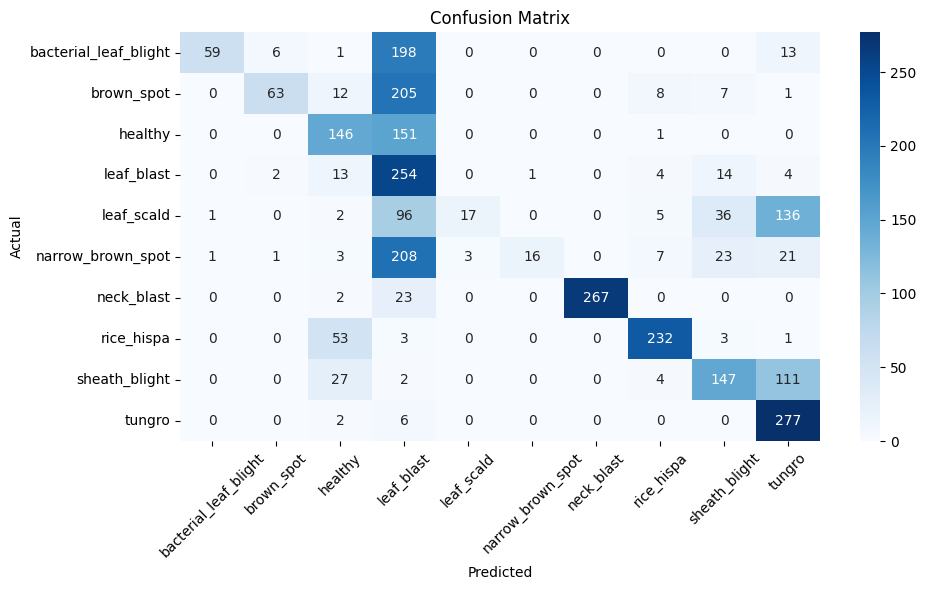


Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.97      0.21      0.35       277
           brown_spot       0.88      0.21      0.34       296
              healthy       0.56      0.49      0.52       298
           leaf_blast       0.22      0.87      0.35       292
           leaf_scald       0.85      0.06      0.11       293
    narrow_brown_spot       0.94      0.06      0.11       283
           neck_blast       1.00      0.91      0.96       292
           rice_hispa       0.89      0.79      0.84       292
        sheath_blight       0.64      0.51      0.56       291
               tungro       0.49      0.97      0.65       285

             accuracy                           0.51      2899
            macro avg       0.74      0.51      0.48      2899
         weighted avg       0.74      0.51      0.48      2899



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Ensure validation_generator is not shuffled ---
# If not already done earlier, re-define it here with shuffle=False
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training'  # Subset for training
)
# Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation' ,
    shuffle=False
)

# --- Get true labels from validation set ---
Y_true = validation_generator.classes

# --- Predict class probabilities using the trained model ---
# Cast the result of np.ceil to an integer for the 'steps' argument
Y_pred_probs = model.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / validation_generator.batch_size)))

# --- Get predicted class indices ---
Y_pred = np.argmax(Y_pred_probs, axis=1)

# --- Get class names ---
class_names = list(validation_generator.class_indices.keys())

# --- Generate the confusion matrix ---
cm = confusion_matrix(Y_true, Y_pred)

# --- Plot the confusion matrix ---
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Print classification report ---
print("\nClassification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_names))

91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - accuracy: 0.3614 - loss: 3.2028
Test Accuracy: 50.98%


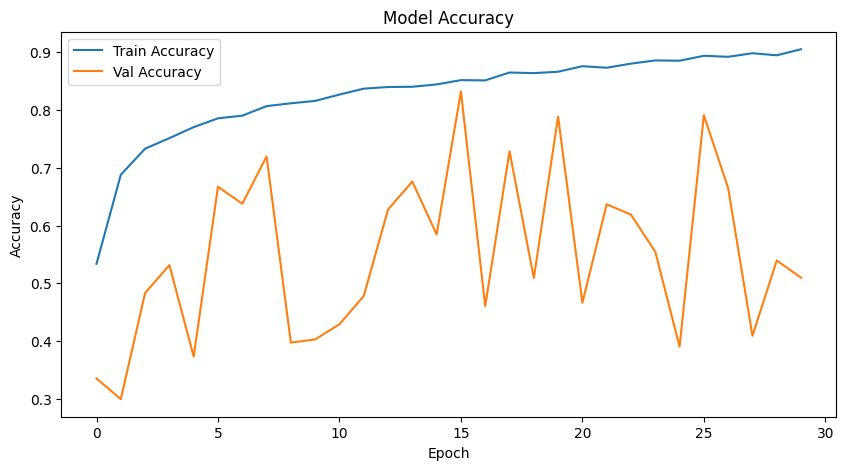

In [18]:
loss, acc = model.evaluate(validation_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Plot accuracy graph

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


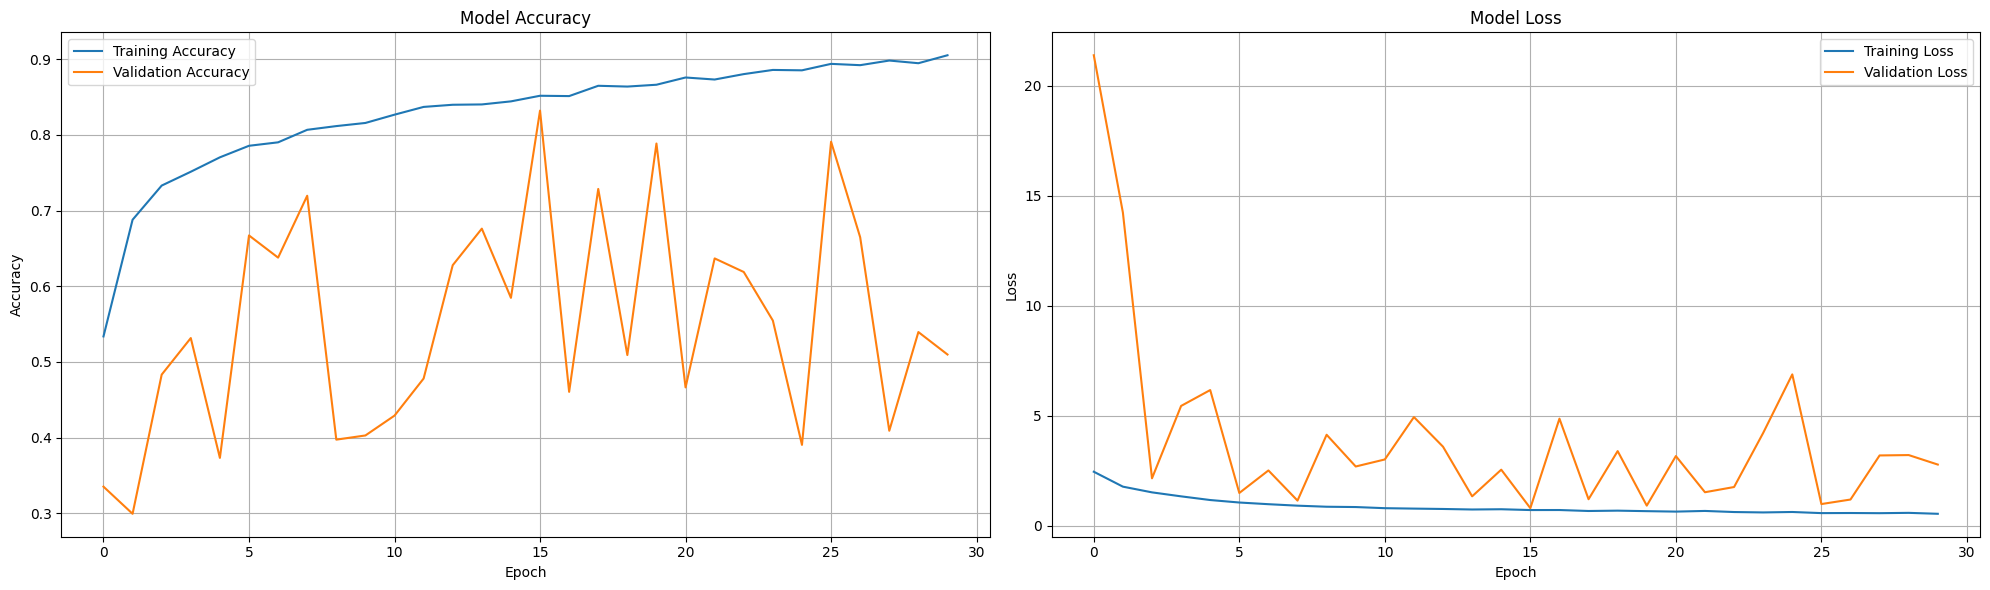

In [19]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(20,6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
model.save('/kaggle/working/trained _models1/paddy_basic_cnn_leaf_inceptionv3_model.h5')


In [21]:
# Accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

# Loss
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Training Accuracy:   {train_acc * 100:.2f}%")
print(f"Training Loss:       {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss:     {val_loss:.4f}")


Training Accuracy:   90.51%
Training Loss:       0.5366
Validation Accuracy: 50.98%
Validation Loss:     2.7741


In [22]:
correct = 0
total = 0

for i in range(len(test_generator)):
    try:
        x, y_true = test_generator[i]
        y_pred = model.predict(x)
        correct += np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
        total += x.shape[0]
    except Exception as e:
        print(f"Skipping batch {i} due to error: {e}")

print(f"Test Accuracy: {(correct / total) * 100:.2f}%")


Skipping batch 0 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed1/bacterial_leaf_blight/BACTERIALBLIGHT2_100.jpg'
Skipping batch 1 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed1/bacterial_leaf_blight/bacterial_leaf_blight (113).jpg'
Skipping batch 2 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed1/bacterial_leaf_blight/bacterial_leaf_blight (163).jpg'
Skipping batch 3 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed1/bacterial_leaf_blight/bacterial_leaf_blight (169).JPG'
Skipping batch 4 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed1/bacterial_leaf_blight/bacterial_leaf_blight (194).JPG'
Skipping batch 5 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed1/bacterial_leaf_blight/bacterial_leaf_blight (223).jpg'
Skipping batch 6 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed